In [1]:
%load_ext autoreload
%autoreload 2 

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from hetgpy import homGP, hetGP
import pandas as pd
import yaml
from typing import Dict
import json
from collections import Counter, defaultdict

from helpers import *

from eqsql import worker_pool, db_tools, cfg
from eqsql.task_queues import local_queue

#### Setup EMEWS DB

In [2]:

config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)

exp_id = 1
# start database
db_tools.stop_db(params['db_path'])
db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
db_started = True

# start local task queue
task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                            port=None, db_name=params['db_name'])

# check if the input and output queues are empty,
# if not, then exit with a warning.
if not task_queue.are_queues_empty():
    print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
    task_queue.clear_queues()

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/Users/abbystevens/Documents/db/emews_db/db.log
Database server started


#### Generate grid and initial sample

In [3]:
# set up grid
xx = np.linspace(0, 1, 30)
Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))

# generate some seeds
seeds = np.random.choice(100, 20, replace=False)

# budget
budget = 50
nts = 10 #number of new points per thompson sample

# initialize 
init_ids = [217, 233, 465, 697, 713]
init_reps = 3
init_ids = {x:init_reps for x in init_ids}
budget -= len(init_ids)*init_reps

init_seeds = seeds[:init_reps]
id_counter = Counter()

X, Xnative = generate_inputs(Xgrid, init_ids, id_counter, seeds)

#### Submit initial payload to run simulations on initially selected points

In [5]:
# start worker pool
pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                    exp_id, pool_params)
task_type = params['task_type']

# run initial simulations
payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])


#### Fit GP on initial sample

Homoskedastic model has higher log-likelihood: 
 -9.133986703125014  compared to  -9.203376027773562 

Return homoskedastic model 



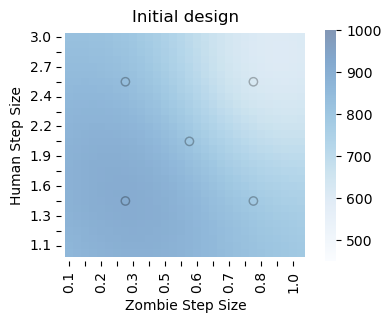

In [6]:
# normalizing Y for numerical stability
Y = np.log(Y)
ymean, ystd = Y.mean(), Y.std()
Y = (Y-ymean)/ystd

gp = hetGP()
gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), init={'g_bounds':[1e-6, .1]})

plot_gp_mean(gp, Xgrid, X, ymean, ystd, title='Initial design')

#### Initial Thompson Sample

In [7]:
import time
t0 = time.time()
best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
print(time.time() - t0)


58.151357889175415


#### Keep sampling til budget is spent

In [ ]:
i = 1
while budget > 0:
    # thompson sample for best locations
    #best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    #budget -= nts
    
    # get new runs and combine
    Xnew_native = []
    Xnew = []
    for ix, cnt in best_ids.items():
        start = id_counter[ix]
        end = id_counter[ix] + cnt
        Xt, Xt_native = generate_inputs(Xgrid, best_ids, id_counter, seeds)
        Xnew.append(Xt)
        Xnew_native.append(Xt_native)
    Xnew = np.vstack(Xnew)
    Xnew_native = np.vstack(Xnew_native)
    payloads = list(map(lambda a: json.dumps(list(a)), Xnew_native))
    _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
    sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
    Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
    # scale outputs
    Ynew = np.log(Ynew)
    Ynew = (Ynew - ymean)/ystd

    X = np.vstack([X, Xnew])
    Y = np.concatenate([Y, Ynew])

    Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
    Ynative = Ynative = np.exp(Y*ystd + ymean)
    best_ix = np.argmax(Ynative)
    print(f"After iteration {i}, we found that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
    gp = hetGP()
    gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), 
           init={'g_bounds':[1e-6, .1]}, maxit=1000)
    plot_gp_mean(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    i += 1


#### Close DB

In [ ]:
if task_queue is not None:
    task_queue.close()
if pool is not None:
    pool.cancel()
if db_started:
    db_tools.stop_db(params['db_path'])